In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [3]:
path = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/raw/'
name = 'data_2024-05-03_15-32.csv'

data_raw = pd.read_csv(path+name)

# 1. Data Cleaning

In [4]:
n_errors = data_raw[data_raw['Name']=='error'].shape[0]
perc = n_errors / data_raw.shape[0]
print(f'{n_errors} car ads of {data_raw.shape[0]} does not scraped. Percentage: {round(perc*100,2)}%')

data_clean = data_raw[data_raw['Name']!='error'].reset_index(drop=True)

6843 car ads of 25895 does not scraped. Percentage: 26.43%


Clean the brand name column

In [5]:
data_clean['Name_clean'] = data_clean['Name'].apply(lambda text: text.split()[0])
data_clean = data_clean[data_clean['Name_clean']!='Αυτοκίνητο']
conditions = [data_clean['Name_clean']=='Mini', data_clean['Name_clean']=='Land', data_clean['Name_clean']=='Alfa', data_clean['Name_clean']=='Aston', data_clean['Name_clean']=='Rolls', data_clean['Name_clean']=='Austin']
values = ['Mini-Cooper', 'Land-Rover', 'Alfa-Romeo', 'Aston-Martin', 'Rolls-Royce', 'Austin-Morris']
data_clean['Name_clean'] = np.select(conditions, values, default=data_clean['Name_clean'])

Split and clean "Info" column to individuals and merge to the main dataframe

In [6]:
info_columns = data_clean['Info'].str.split(',', expand=True)
info_columns[0] = pd.to_datetime(info_columns[0], format='%m/%Y')

info_columns = info_columns[info_columns[1].str.contains('χλμ')]
info_columns[1] = info_columns[1].str.replace('.', '',regex=False).str.replace('χλμ', '',regex=False).astype(float)

info_columns = info_columns[info_columns[2].str.contains('cc')]
info_columns[2] = info_columns[2].str.replace('.', '',regex=False).str.replace('cc', '',regex=False).astype(float)

info_columns[3] = info_columns[3].str.replace('.', '',regex=False).str.replace('bhp', '',regex=False).astype(float)

conditions = [info_columns[4].isin([' Αυτόματο', ' Ημιαυτόματο'])]
values = [info_columns[4]]
info_columns['GearBox'] = np.select(conditions, values, default='Manual')
info_columns['GearBox'] = info_columns['GearBox'].str.strip(' ')

conditions = [(info_columns[4] == ' Αυτόματο') | (info_columns[4] == ' Ημιαυτόματο')]
values = [info_columns[5]]
info_columns[4] = np.select(conditions, values, default=info_columns[4])
info_columns[4] = info_columns[4].str.strip(' ')

info_columns.drop([5,6,7], axis=1, inplace=True)

data_clean_merged = pd.merge(data_clean, info_columns, left_index=True, right_index=True)
data_clean_merged.drop(['Info'], axis=1, inplace=True)

data_clean_merged.columns = ['FullName','Price','Name','ProductionDate','Klm','CubicCapacity','Horsepower','GasType', 'GearBox']

# 2. Feature Engineering

In [7]:
reference_year = 2024
data_clean_merged['Age'] = reference_year - data_clean_merged['ProductionDate'].dt.year
data_clean_merged.drop(['FullName', 'ProductionDate'], inplace=True, axis=1)

## Outliers Halding

In [8]:
data_clean_merged_filtered = data_clean_merged[data_clean_merged['Price']>1000]

Filter out the car brands that have less than 20 ads. Not big reduction of the dataset

In [9]:
counts_df = pd.DataFrame(data_clean_merged_filtered['Name'].value_counts())
counts_df.columns = ['count']
counts_df = counts_df[counts_df['count'] >= 20]
name_list = list(counts_df.index)

print(f'{data_clean_merged_filtered.shape[0]} rows, {data_clean_merged_filtered.shape[1]} attributes before filter')
data_clean_merged_filtered = data_clean_merged_filtered[data_clean_merged_filtered['Name'].isin(name_list)]
print(f'{data_clean_merged_filtered.shape[0]} rows, {data_clean_merged_filtered.shape[1]} attributes after filter')

18481 rows, 8 attributes before filter
18304 rows, 8 attributes after filter


Klm attribute -  an average klm count for a car per year is roughly 10-20k  
so the dataset will be filtered for records that have less than 10.000 klm and less than a year age.

In [10]:
mask = data_clean_merged_filtered[(data_clean_merged_filtered['Klm'] <= 10_000) & (data_clean_merged_filtered['Age'] >= 1)].index
data_clean_merged_filtered = data_clean_merged_filtered.drop(mask).reset_index(drop=True)

Horsepower attribute - remove records with horsepower equal to zero.

In [11]:
data_clean_merged_filtered = data_clean_merged_filtered[data_clean_merged_filtered['Horsepower'] != 0].reset_index(drop=True)

# 3. Exploratory Data Analysis

In [12]:
data = data_clean_merged_filtered.copy()

num_cols = ['Price', 'Klm', 'CubicCapacity', 'Horsepower', 'Age']
categorical_cols = ['Name', 'GasType', 'GearBox']

#### Distribution of target attribute (Non-Normality)

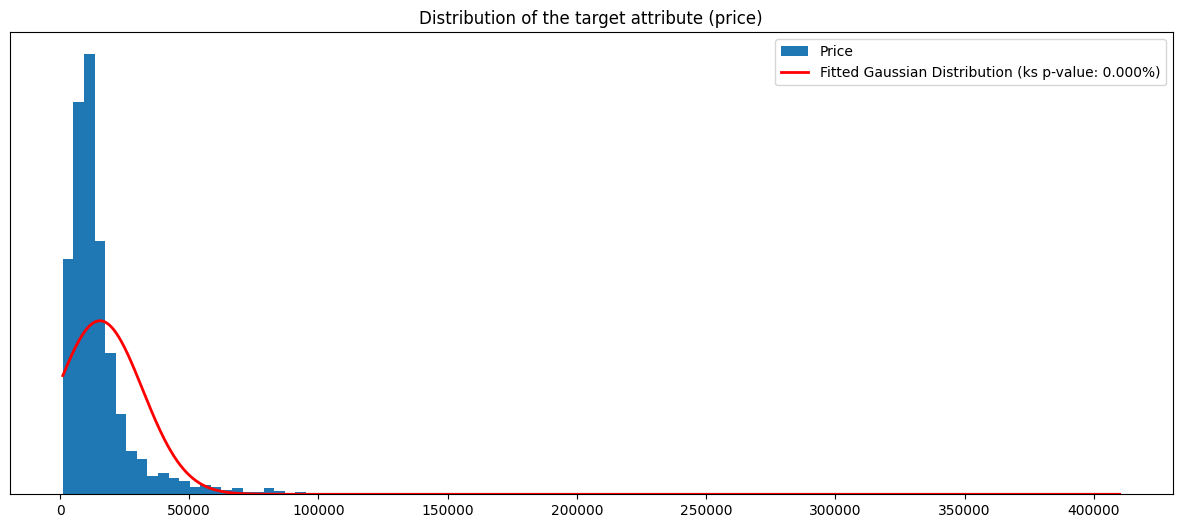

In [13]:
x = data['Price']

# generate x values for distribution plot
x_dist = np.linspace(min(x), max(x), 1000)
mean, std_dev = np.mean(x), np.std(x)
# normal
dist_normal_cdf = stats.norm(loc=mean, scale=std_dev).cdf
statistic_normal, pvalue_normal = stats.ks_1samp(x, dist_normal_cdf)
dist_normal = stats.norm.pdf(x_dist, mean, std_dev)

# exponential
dist_expon_cdf = stats.expon(loc=mean, scale=std_dev).cdf
statistic_expon, pvalue_expon = stats.ks_1samp(x, dist_expon_cdf)
dist_expon = stats.expon.pdf(x_dist, mean, std_dev)

# gamma
a=1.5
dist_gamma_cdf = stats.gamma(a=a, loc=mean, scale=std_dev).cdf
statistic_gamma, pvalue_gamma = stats.ks_1samp(x, dist_gamma_cdf)
dist_gamma = stats.gamma.pdf(x_dist, a, mean, std_dev)

plt.figure(figsize=(15, 6))
plt.hist(data['Price'], bins=100, density=True, label='Price')
plt.plot(x_dist, dist_normal, color='red', lw=2, label=f'Fitted Gaussian Distribution (ks p-value: {pvalue_normal:.3%})')
# plt.plot(x_dist, dist_expon, color='green', lw=2, label=f'Fitted Exponential Distribution (ks p-value: {pvalue_expon:.3%})')
# plt.plot(x_dist, dist_gamma, color='orange', lw=2, label=f'Fitted Gamma Distribution (ks p-value: {pvalue_gamma:.3%})')
plt.legend()
plt.yticks([])
plt.title('Distribution of the target attribute (price)')
plt.show()

#### Categorical Attributes

In order to determine if each categorical attribute affects the price of cars the [kruskal wallis h test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) will be used.

In [14]:
# perform the kw test for a significance level of 5%
sign_level = 0.05
for categorical_col in categorical_cols: 
    groups = [data[data[categorical_col] == g]['Price'] for g in data[categorical_col].unique()]
    stat, p_value = stats.kruskal(*groups)
    if p_value < 0.05:
        print(f'P-value of the test: {p_value:.8%}')
        print(f'Different categories of {categorical_col} attribute affect the price of the car.')

P-value of the test: 0.00000000%
Different categories of Name attribute affect the price of the car.
P-value of the test: 0.00000000%
Different categories of GasType attribute affect the price of the car.
P-value of the test: 0.00000000%
Different categories of GearBox attribute affect the price of the car.


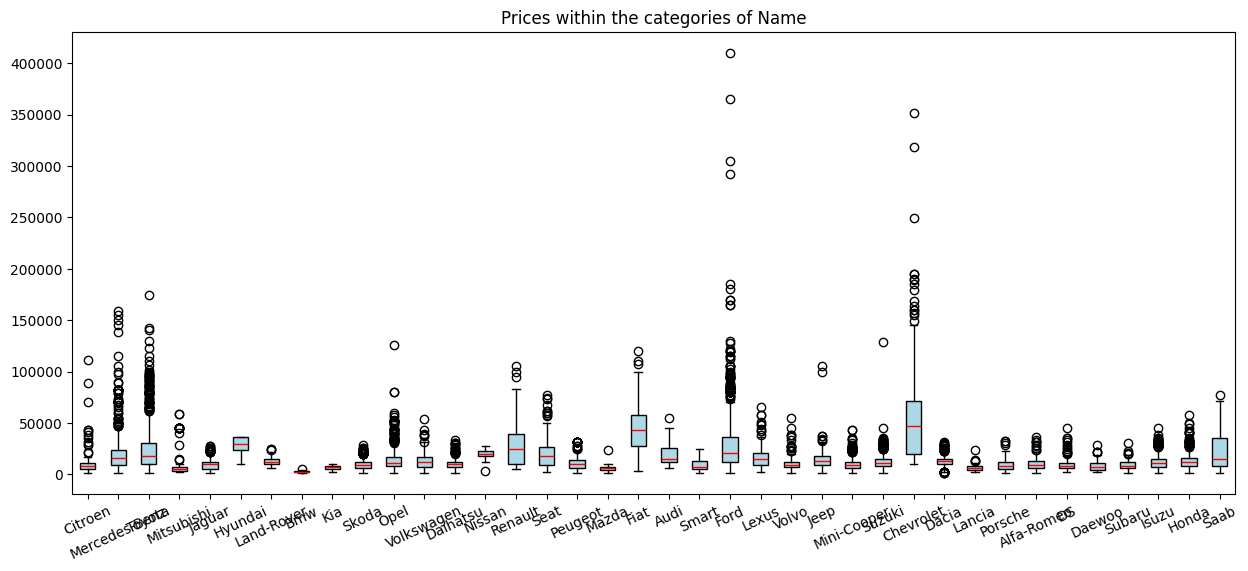

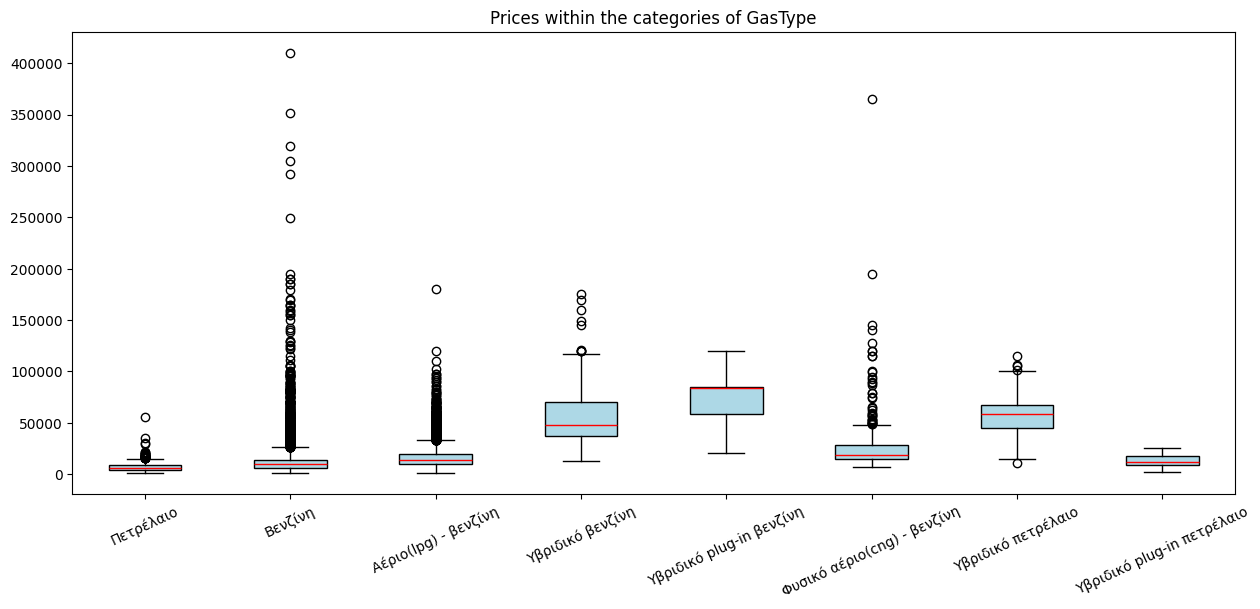

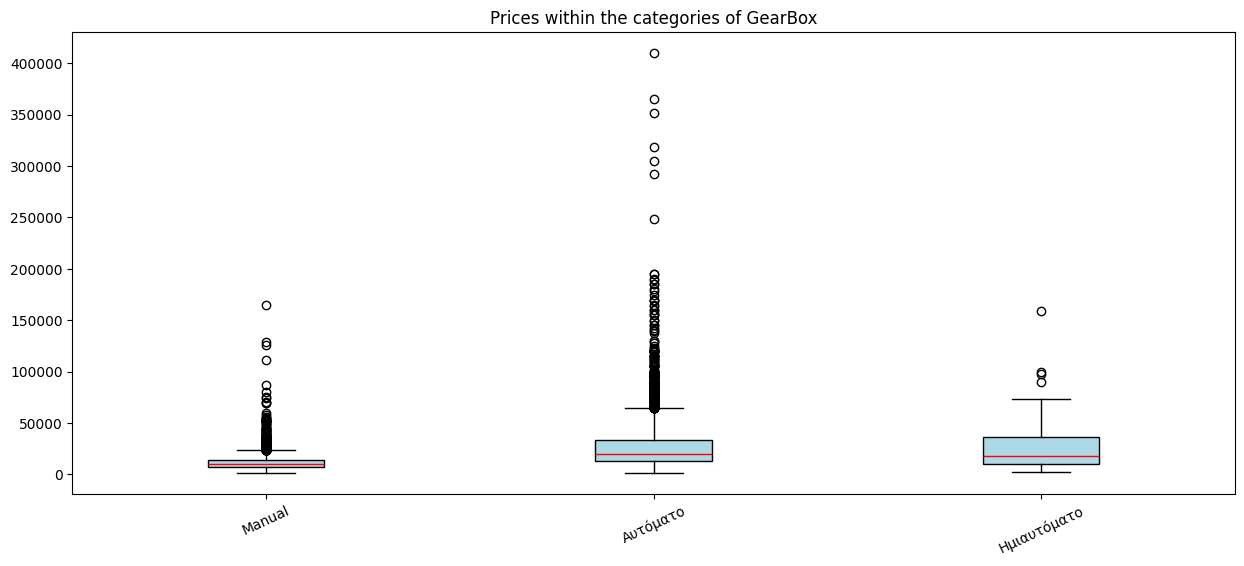

In [15]:
def make_boxplot(categorical_col):
    unique_values = data[categorical_col].unique()
    grouped_data = [group['Price'].values for name, group in data.groupby(categorical_col)]
    plt.figure(figsize=(15, 6))
    box = plt.boxplot(grouped_data, tick_labels=unique_values, patch_artist=True)
    plt.xticks(rotation = 25)
    for patch in box['boxes']:
        patch.set_facecolor('lightblue')
    plt.setp(box['medians'], color='red')
    plt.title(f'Prices within the categories of {categorical_col}')
    plt.show()

for categorical_col in categorical_cols:
    make_boxplot(categorical_col)

#### Numerical Attributes

In [16]:
def num_format(x):
    return f'{x:,.2f}'

data[num_cols].describe().map(num_format).loc['mean':]

,Price,Klm,CubicCapacity,Horsepower,Age
mean,"15,433.33","141,438.22","1,632.33",134.62,11.65
std,"16,455.76","77,181.94",628.12,81.58,7.37
min,"1,090.00",112.00,1.00,1.00,0.00
25%,"7,500.00","91,000.00","1,272.50",90.00,6.00
50%,"11,490.00","133,000.00","1,500.00",112.00,9.00
75%,"17,000.00","180,000.00","1,800.00",150.00,16.00
max,"410,000.00","1,750,000.00","10,000.00","1,100.00",88.00


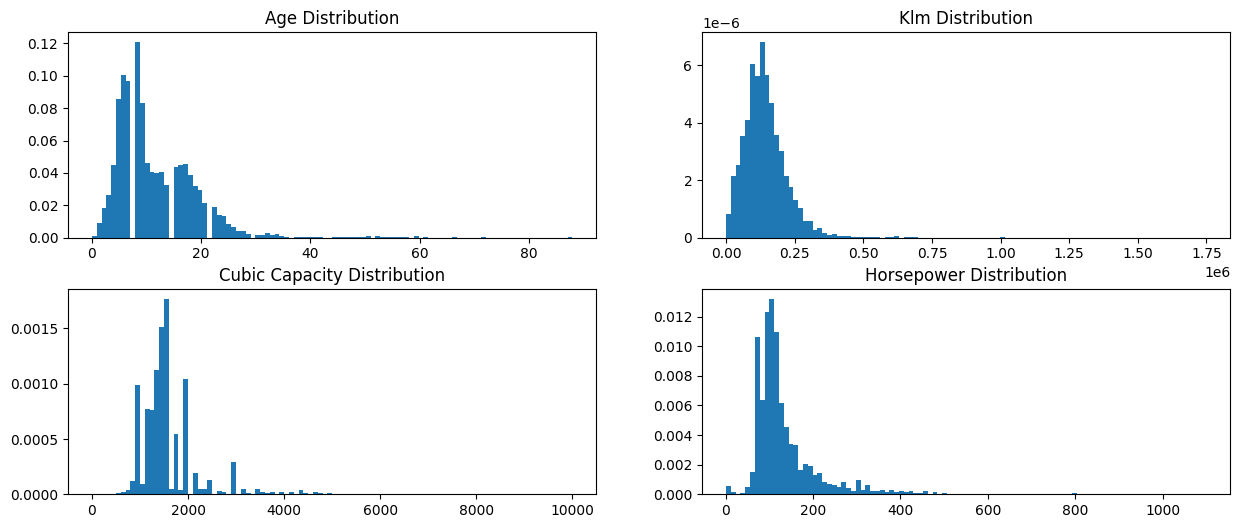

In [17]:
# Check the distributions
fig, axs = plt.subplots(2,2, figsize=(15,6), gridspec_kw={'hspace':.25})
axs[0, 0].hist(data['Age'], bins=100, density=True)
axs[0, 0].title.set_text('Age Distribution')

axs[0, 1].hist(data['Klm'], bins=100, density=True)
axs[0, 1].title.set_text('Klm Distribution')

axs[1, 0].hist(data['CubicCapacity'], bins=100, density=True)
axs[1, 0].title.set_text('Cubic Capacity Distribution')

axs[1, 1].hist(data['Horsepower'], bins=100, density=True)
axs[1, 1].title.set_text('Horsepower Distribution')

plt.show()

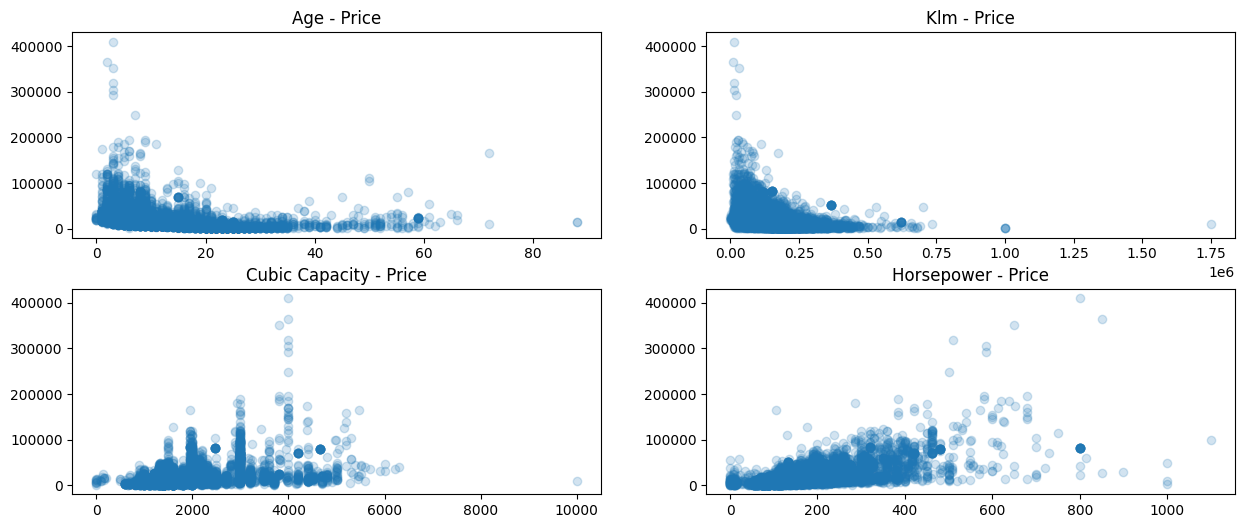

In [18]:
# Correlations
fig, axs = plt.subplots(2,2, figsize=(15,6), gridspec_kw={'hspace':.25})
axs[0, 0].scatter(x=data['Age'], y=data['Price'], alpha=.2)
axs[0, 0].title.set_text('Age - Price')

axs[0, 1].scatter(x=data['Klm'], y=data['Price'], alpha=.2)
axs[0, 1].title.set_text('Klm - Price')

axs[1, 0].scatter(x=data['CubicCapacity'], y=data['Price'], alpha=.2)
axs[1, 0].title.set_text('Cubic Capacity - Price')

axs[1, 1].scatter(x=data['Horsepower'], y=data['Price'], alpha=.2)
axs[1, 1].title.set_text('Horsepower - Price')

plt.show()

In [19]:
# non linear correlation between numerical attributes and price

#### Finding Hidden Pattern

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data_dummies = pd.get_dummies(data, prefix_sep = '_')

score_df = pd.DataFrame(columns=['k', 'silhouette_score'])

for k in range(3,10):
    kmeans = KMeans(n_clusters=k).fit(data_dummies)
    s_score = silhouette_score(data_dummies, kmeans.labels_)
    score_df.loc[len(score_df)] = (k, s_score)

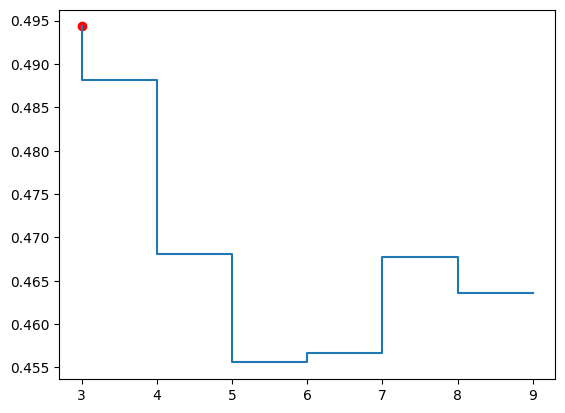

In [89]:
max_index = score_df[score_df.silhouette_score == score_df.silhouette_score.max()].index
plt.step(x=score_df.k, y=score_df.silhouette_score)
plt.scatter(score_df.loc[max_index].values[0][0], score_df.loc[max_index].values[0][1], c='red')
plt.show()

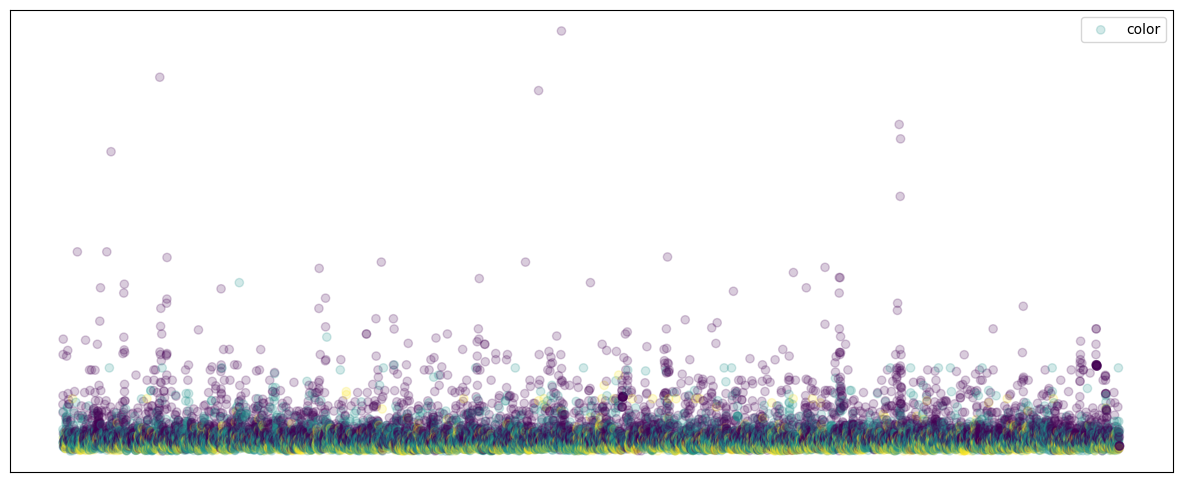

In [57]:
data['Cluster'] = kmeans.labels_

plt.figure(figsize=(15,6))
plt.scatter(data.index, data['Price'], alpha=0.2, c=data['Cluster'], label='color')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# 4. Save Data

In [21]:
save_path = r'C:/Users/Nick/Documents/Data Science/Personal projects/car-price-prediction/data/clean/'
file_name = 'data_clean_20240509.csv'

data_clean_merged_filtered.to_csv(save_path+file_name, sep=';', index=False)
print('Data Saved')

Data Saved
